In [67]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
import matplotlib.ticker as ticker
import math

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [68]:
df = pd.read_csv("Output/data_clean&processed_addedsentiment.csv")
print(df.shape)
df.head(2)

(985, 52)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments,story_afinn,faq_comments_afinn,blurb_name_afinn,blurb_afinn,name_afinn
0,1,With your help we will create this device that...,"{'id': 331, 'name': '3D Printing', 'slug': 'te...",1,ES,2015-08-18 21:01,USD,2016-07-09 20:11,1.212886,15000,...,0,1.0,-1.0,With your help we will create this device that...,[' ']No comments yet.,-10.0,-1.0,4.0,2.0,2.0
1,2,We at Ormiston Primary are looking at starting...,"{'id': 309, 'name': 'Farms', 'slug': 'food/far...",9,NZ,2015-08-11 18:04,USD,2015-09-11 15:55,0.723585,5000,...,0,7.5,-1.0,We at Ormiston Primary are looking at starting...,[' ']No comments yet.,15.0,-1.0,1.0,1.0,0.0


In [6]:
print(len(df.columns.tolist()))
df.columns.tolist()

52


['backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'created_at',
 'current_currency',
 'deadline',
 'fx_rate',
 'goal',
 'id',
 'launched_at',
 'location',
 'name',
 'pledged',
 'profile',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'static_usd_rate',
 'urls',
 'usd_pledged',
 'usd_type',
 'story',
 'faq',
 'num_faq',
 'comments',
 'n_comments',
 'duration',
 'parent_category',
 'category_name',
 'location_name',
 'month_launched',
 'year_launched',
 'backers_count_log',
 'goal_log',
 'pledged_log',
 'duration_log',
 'n_comments_log',
 'num_faq_bool',
 'avg_fund_per_backer',
 'comments_afinn',
 'blurb_name',
 'faq_comments',
 'story_afinn',
 'faq_comments_afinn',
 'blurb_name_afinn',
 'blurb_afinn',
 'name_afinn']

In [9]:
# Cols for OHE 
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name', 'location_name']

# Other feature cols for modelling
cols_to_keep = ['backers_count', 'fx_rate', 'goal', 'pledged', 'n_comments', 'duration', 'month_launched', 'year_launched', 'avg_fund_per_backer', 'num_faq_bool']
sentiment_cols = ['comments_afinn', 'faq_comments_afinn', 'blurb_name_afinn', 'blurb_afinn', 'name_afinn', 'story_afinn']
target_col = ['state']

#Cols to drop
text_cols = ['blurb', 'name', 'story', 'faq', 'comments', 'blurb_name', 'faq_comments']
log_cols = ['backers_count_log', 'goal_log', 'pledged_log', 'duration_log', 'n_comments_log']
other_cols = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 
              'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 
              'usd_pledged', 'converted_pledged_amount', 'spotlight', 'num_faq']

In [11]:
cols_to_drop = text_cols + log_cols + other_cols
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

(985, 23)


# Train Test Split

In [12]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [13]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [14]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

# For Decision Tree
OHE_df = OHE_df.drop(OHE_df.loc[:, OHE_df.columns.str.contains('_log')].columns.tolist(), axis=1)

In [15]:
# Resplit X dataset with OHE columns
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [22]:
print('Before OHE, n features = ', X_train.shape[1])
print('After OHE, n features = ', OHE_train.shape[1])

Before OHE, n features =  22
After OHE, n features =  612


# DecisionTreeClassifier

In [52]:
from sklearn.tree import DecisionTreeClassifier

# Build Model
dt_estimator = tree.DecisionTreeClassifier(random_state=40)

In [53]:
max_depth = [4,5,6,7]
min_samples_split = [20,25,30,35,40,50,60]
min_samples_leaf = [20,25,30,35,40,50,70]

param_grid = {'criterion': ['entropy', 'gini'], 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf}

grid_dt_class = GridSearchCV(estimator = dt_estimator, param_grid = param_grid, 
                             scoring='accuracy', n_jobs=-1, cv = 10, 
                             refit=True, return_train_score=True)

grid_dt_class.fit(OHE_df, y)

print(grid_dt_class.best_params_)
print("Model score: ", grid_dt_class.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 50}
Model score:  0.9309626881055453


In [65]:
# Evaluate Model 
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 4,
                               min_samples_leaf= 20,
                               min_samples_split= 50, random_state = 40
                              )
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)


The evaluation report is:
Confusion Matrix:
[[ 61   9]
 [  0 127]]
Accuracy: 0.9543147208121827



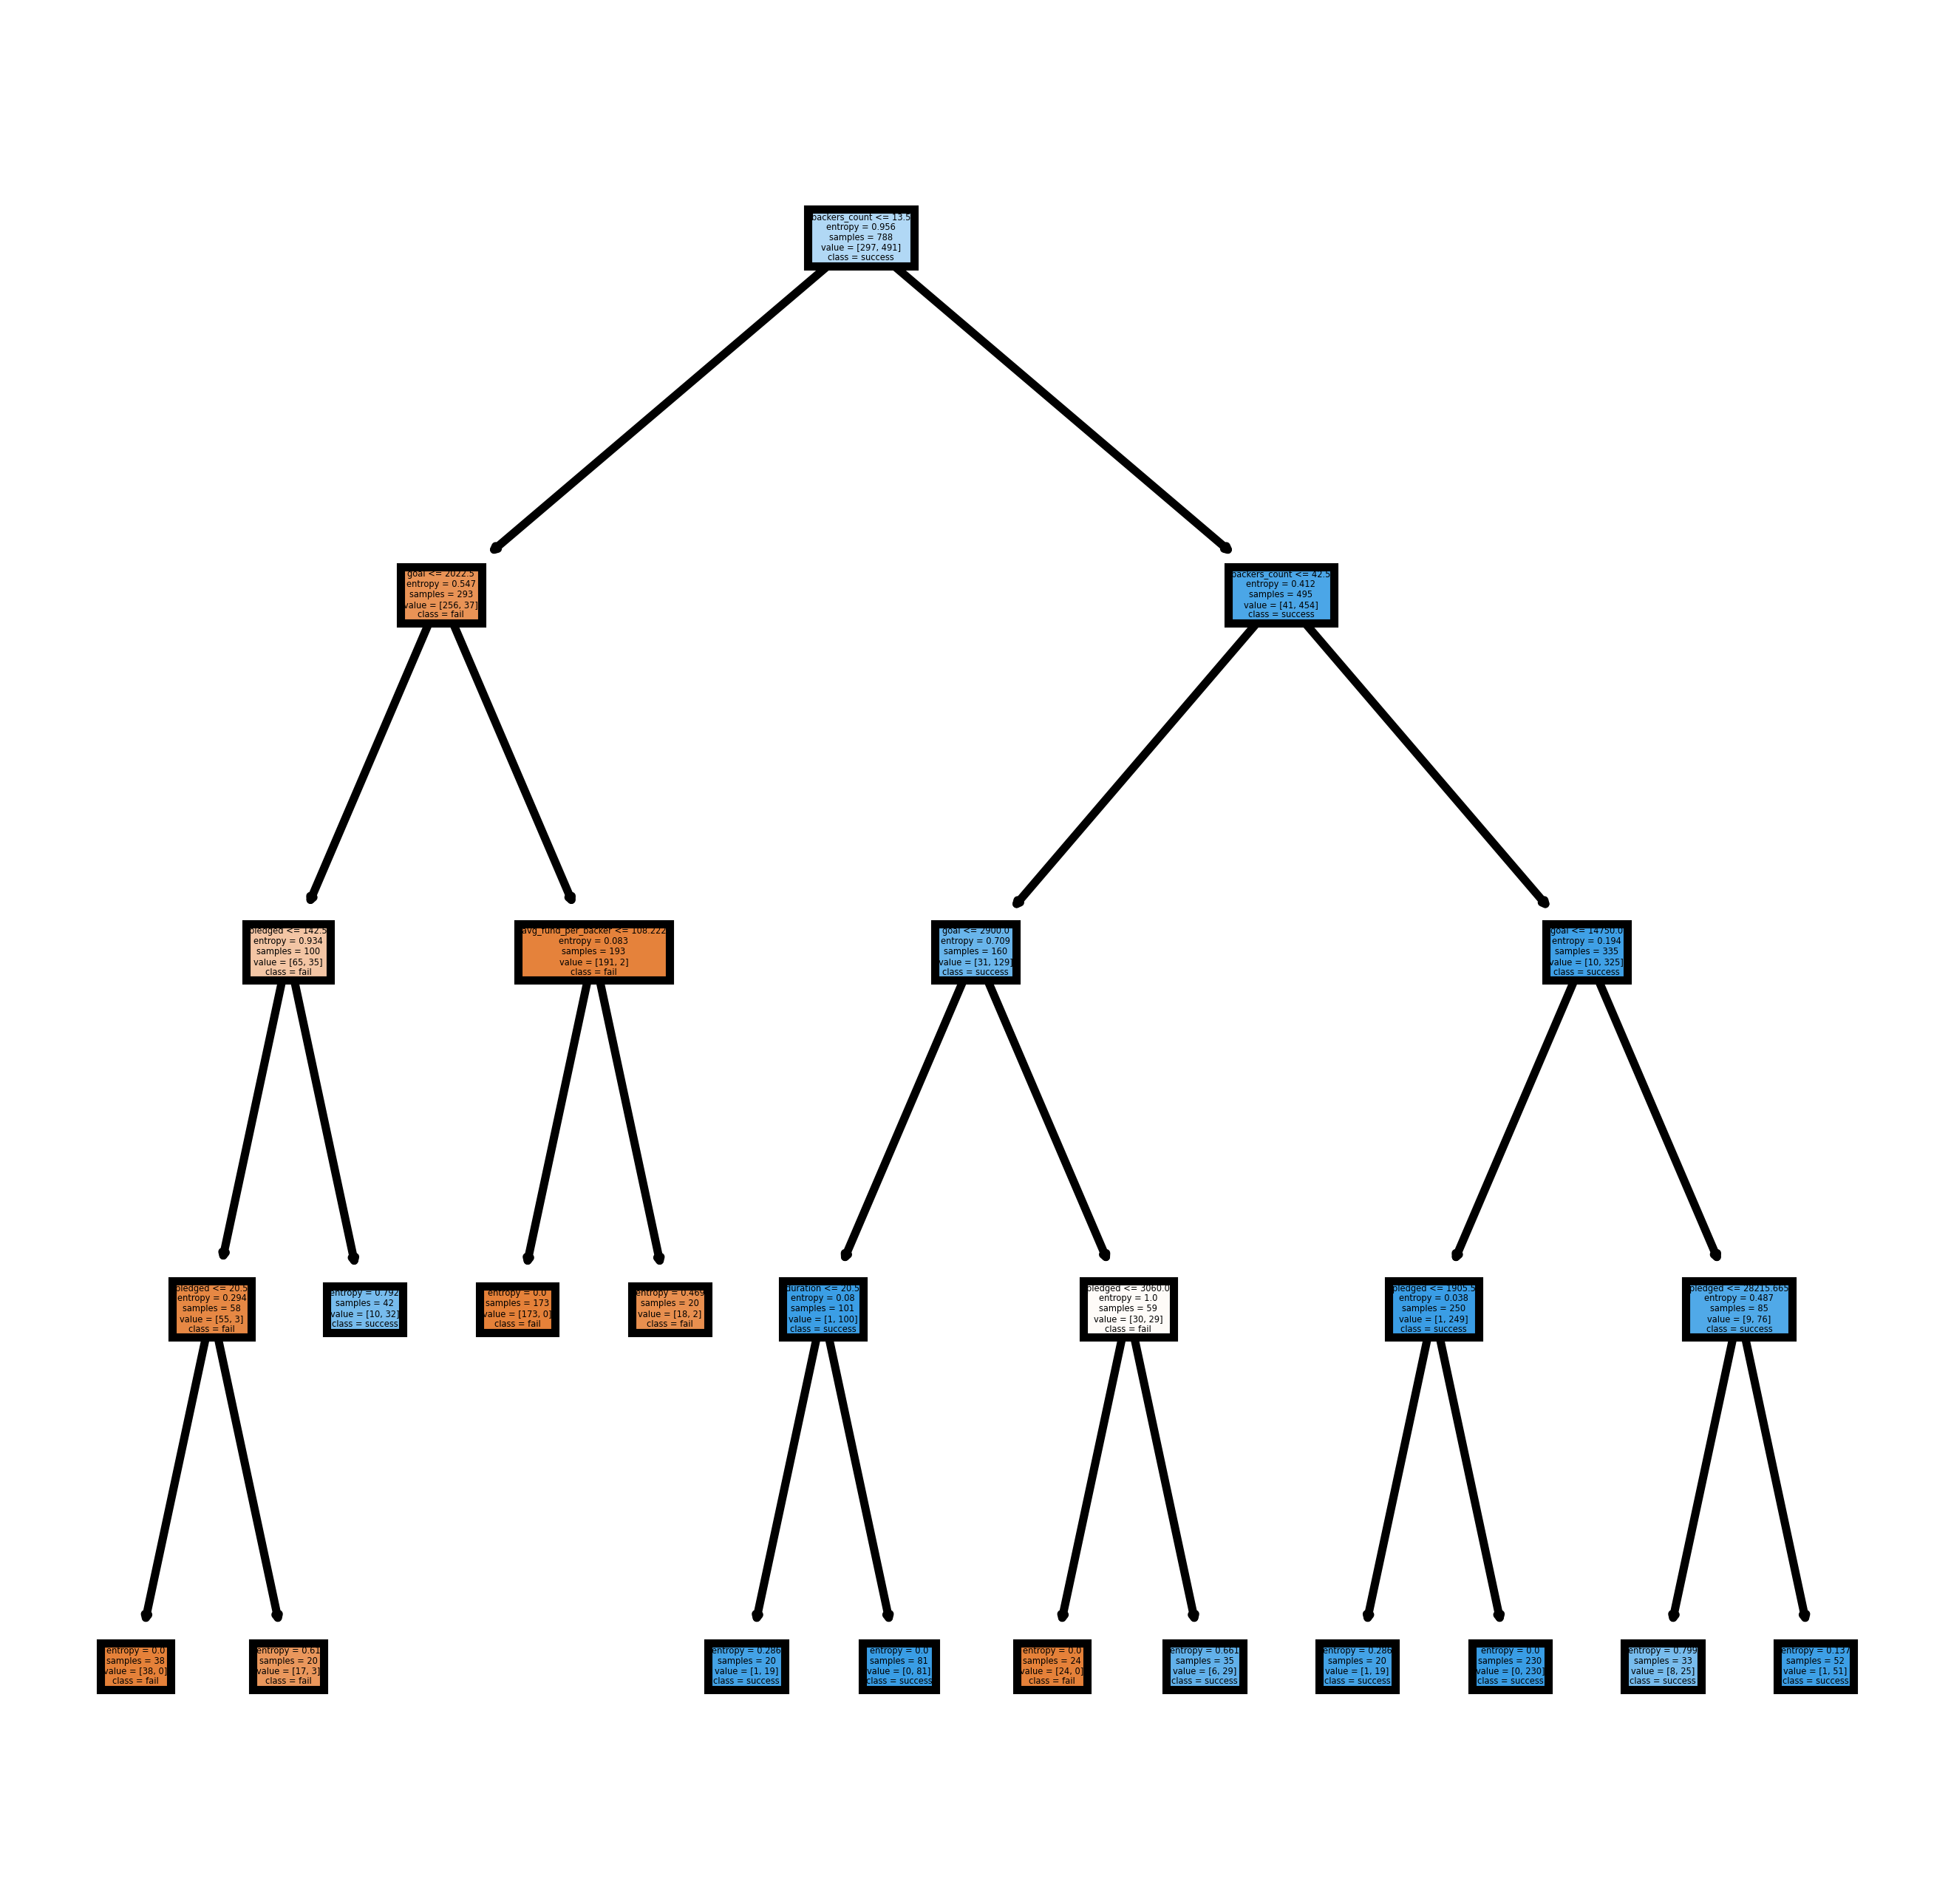

In [66]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

# Feature Importance

In [62]:
important_features_dict = {}
for idx, val in enumerate(dtree.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dtree.feature_importances_[top_idx]

print('Top 5 most important features: \n')

for i in range(5):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Top 5 most important features: 

1: backers_count, Score: 0.658 
2: goal, Score: 0.177 
3: pledged, Score: 0.151 
4: avg_fund_per_backer, Score: 0.011 
5: duration, Score: 0.004 
